# RF Sensitivity Analysis - Supermodel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']


    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - (q_H * E_H * H) - (m_H * H)
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -(PH * (v_m * N) / (k_s + N)) + (0.5 * m_ph * PH) + (0.5 * m_H * H) + (1 * y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                0.5 * m_P * P)

    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [5]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.15/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.15/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [6]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

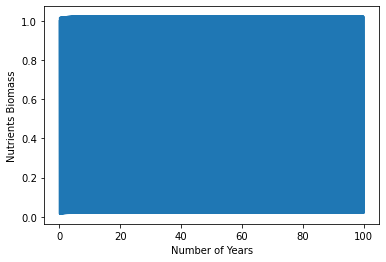

In [7]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

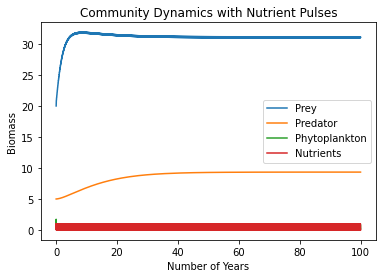

In [8]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

# Running through params

### Interested in $r_H, K_H, d, E_H, m_H, r_P, K_P, E_P, m_P, v_m, k_s, m_ph, y, r_m, kg$ 

In [9]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.15/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.15/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

### Function to run through params of interest at +/- 10%

In [10]:
# Function to vary parameters and document all parameter values
def run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0):
    # Initialize an empty list to store all results
    all_results = []
    
    # Loop through each parameter to vary
    for param in params_to_vary:
        # Store the original value of the parameter
        original_value = parameters_dict[param]
        
        # Generate values to vary the parameter within the specified range
        varied_values = np.linspace(
            original_value * (1 - variation_range),  # Lower bound
            original_value * (1 + variation_range),  # Upper bound
            10  # Number of variations (adjustable)
        )
        
        # Loop through each varied value for the current parameter
        for value in varied_values:
            # Update the parameter in the dictionary
            parameters_dict[param] = value
            
            # Run the model with the updated parameters
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(
                H0, P0, PH0, N0, parameters_dict
            )
            
            # Create a dictionary to store the results for this run
            result = {
                'H_final': H_array[-1],
                'P_final': P_array[-1],
                'PH_final': PH_array[-1],
                'N_final': N_array[-1]
            }
            
            # Add all parameter values to the result
            result.update(parameters_dict)
            
            # Append the result to the list
            all_results.append(result)
        
        # Reset the parameter to its original value
        parameters_dict[param] = original_value
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

### Testing Function to make sure works

In [11]:
# Specify parameters to vary and their variation range
params_to_vary = ['r_H', 'K_H', 'd', 'E_H', 'm_H','r_P','K_P', 'E_P', 'm_P', 'v_m', 'k_s', 'm_ph', 'r_m','y', 'kg']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

       H_final   P_final  PH_final   N_final  numyears       r_H   K_H  \
0    30.336286  9.101376  0.213160  0.019701     36500  0.000986  50.0   
1    30.509872  9.155116  0.212453  0.019792     36500  0.001011  50.0   
2    30.681451  9.208006  0.211761  0.019883     36500  0.001035  50.0   
3    30.851026  9.260057  0.211084  0.019972     36500  0.001059  50.0   
4    31.018599  9.311279  0.210422  0.020060     36500  0.001084  50.0   
..         ...       ...       ...       ...       ...       ...   ...   
145  31.088413  9.332535  0.213423  0.019938     36500  0.001096  50.0   
146  31.061913  9.324423  0.220108  0.019617     36500  0.001096  50.0   
147  31.035346  9.316286  0.226833  0.019311     36500  0.001096  50.0   
148  31.008717  9.308127  0.233595  0.019020     36500  0.001096  50.0   
149  30.982031  9.299947  0.240391  0.018741     36500  0.001096  50.0   

     theta_H         c     d       E_H  q_H       m_H       r_P   K_P  \
0          0  0.001096  50.0  0.000411

## Simulation runs - Generalist Current Nutrients

In [12]:
def generalist_current_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.2/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.15/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.2/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.15/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 0.026
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

In [13]:
parameters_dict = generalist_current_params()
params_to_vary = ['r_H', 'K_H', 'd', 'E_H', 'm_H','r_P','K_P', 'E_P', 'm_P', 'v_m', 'k_s', 'm_ph', 'r_m','y', 'kg']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/generalist_current_RF_data.csv', index=False)

       H_final   P_final  PH_final   N_final  numyears       r_H   K_H  \
0    17.964658  0.522330  0.112800  0.019529     36500  0.000986  50.0   
1    18.692313  0.577414  0.113536  0.019938     36500  0.001011  50.0   
2    19.383761  0.632871  0.114197  0.020327     36500  0.001035  50.0   
3    20.042135  0.688410  0.114795  0.020698     36500  0.001059  50.0   
4    20.670147  0.743784  0.115339  0.021053     36500  0.001084  50.0   
..         ...       ...       ...       ...       ...       ...   ...   
145  20.957620  0.769871  0.116464  0.021099     36500  0.001096  50.0   
146  20.926105  0.766957  0.118185  0.020860     36500  0.001096  50.0   
147  20.894969  0.764085  0.119877  0.020631     36500  0.001096  50.0   
148  20.864212  0.761253  0.121539  0.020414     36500  0.001096  50.0   
149  20.833832  0.758461  0.123173  0.020206     36500  0.001096  50.0   

     theta_H         c     d       E_H  q_H       m_H       r_P   K_P  \
0          0  0.000548  50.0  0.000411

### Run RF analysis 

In [9]:
data = pd.read_csv("data/generalist_current_RF_data.csv")

X1 = data.iloc[:, 4:29]  # Columns 4-28 are explanatory
Y1 = data.iloc[:, 0:4]   # Columns 0-4 are response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X1, Y1)

# Predict using the model
predictions = regressor.predict(X1)

# Calculate Mean Squared Error
mse = mean_squared_error(Y1, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y1, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.001263191237834969
R-squared: 0.9878251458772123


Feature Importances:
[0.00000000e+00 4.25914541e-01 2.91893307e-01 0.00000000e+00
 0.00000000e+00 2.44672630e-03 1.77722402e-01 0.00000000e+00
 5.57077864e-02 1.08603996e-02 2.59622948e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.21352710e-02 1.42166584e-04
 3.19683967e-07 3.01377135e-07 1.34932222e-03 4.01058215e-06
 3.25383108e-04 1.23843942e-03 0.00000000e+00 0.00000000e+00]


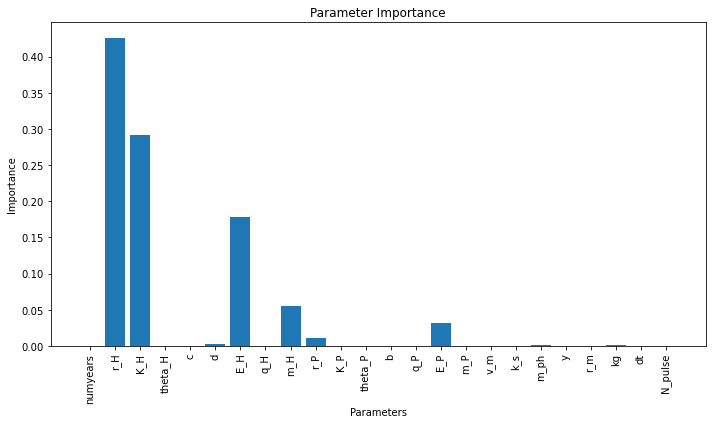

In [10]:
importances1 = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances1)

# Set up labels for the features (adjust based on your column names)
plotLabs1 = X1.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs1, importances1, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

## Simulation runs - Specialist Current Nutrients

In [16]:
def specialist_current_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.8/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.15/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.8/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.15/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 0.026
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

In [17]:
parameters_dict = specialist_current_params()
params_to_vary = ['r_H', 'K_H', 'd', 'E_H', 'm_H','r_P','K_P', 'E_P', 'm_P', 'v_m', 'k_s', 'm_ph', 'r_m','y', 'kg']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/specialist_current_RF_data.csv', index=False)

      H_final   P_final  PH_final   N_final  numyears       r_H   K_H  \
0    8.142379  5.268480  0.098874  0.014250     36500  0.000986  50.0   
1    8.491871  5.661644  0.099929  0.014452     36500  0.001011  50.0   
2    8.844473  6.054820  0.100949  0.014656     36500  0.001035  50.0   
3    9.196693  6.446461  0.101926  0.014861     36500  0.001059  50.0   
4    9.546858  6.835017  0.102858  0.015064     36500  0.001084  50.0   
..        ...       ...       ...       ...       ...       ...   ...   
145  9.708720  7.014226  0.103819  0.015108     36500  0.001096  50.0   
146  9.684764  6.987753  0.104814  0.014998     36500  0.001096  50.0   
147  9.661475  6.962008  0.105776  0.014894     36500  0.001096  50.0   
148  9.638836  6.936973  0.106706  0.014795     36500  0.001096  50.0   
149  9.616831  6.912630  0.107605  0.014701     36500  0.001096  50.0   

     theta_H         c     d       E_H  q_H       m_H       r_P   K_P  \
0          0  0.002192  50.0  0.000411  1.0  0.000

### Run RF Analysis 

In [11]:
data = pd.read_csv("data/specialist_current_RF_data.csv")

X2 = data.iloc[:, 4:29]  # Columns 4-28 are explanatory
Y2 = data.iloc[:, 0:4]   # Columns 0-4 are response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X2, Y2)

# Predict using the model
predictions = regressor.predict(X2)

# Calculate Mean Squared Error
mse = mean_squared_error(Y2, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y2, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.0008027665411920781
R-squared: 0.9881264473142113


Feature Importances:
[0.00000000e+00 5.26747428e-01 4.23987355e-02 0.00000000e+00
 0.00000000e+00 1.17352985e-01 1.19348277e-01 0.00000000e+00
 3.85182462e-02 4.75587642e-03 2.72722075e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.16188916e-01 5.93835696e-04
 3.20358891e-07 3.04817769e-07 3.17207802e-03 9.10623558e-06
 7.52811836e-04 2.88887116e-03 0.00000000e+00 0.00000000e+00]


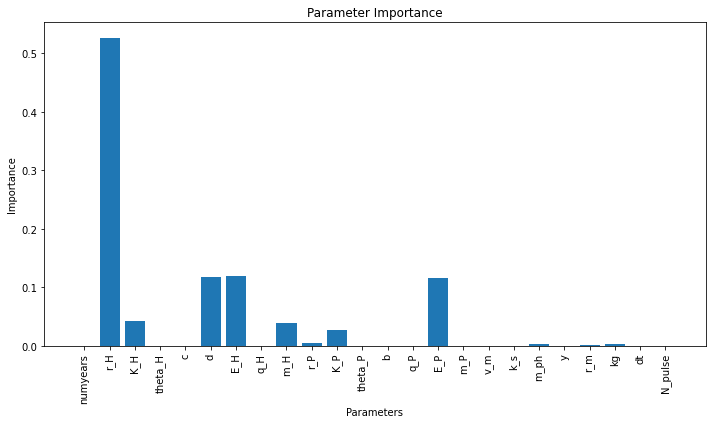

In [12]:
importances2 = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances2)

# Set up labels for the features (adjust based on your column names)
plotLabs2 = X2.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs2, importances2, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

## Simulation runs - Generalist Restored Nutrients

In [20]:
def generalist_restored_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.2/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.15/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.2/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.15/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 0.234
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

In [21]:
parameters_dict = generalist_restored_params()
params_to_vary = ['r_H', 'K_H', 'd', 'E_H', 'm_H','r_P','K_P', 'E_P', 'm_P', 'v_m', 'k_s', 'm_ph', 'r_m','y', 'kg']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/generalist_restored_RF_data.csv', index=False)

       H_final   P_final  PH_final   N_final  numyears       r_H   K_H  \
0    23.708639  1.043883  0.180256  0.017947     36500  0.000986  50.0   
1    24.122994  1.087609  0.179314  0.018165     36500  0.001011  50.0   
2    24.527052  1.130893  0.178417  0.018378     36500  0.001035  50.0   
3    24.921003  1.173674  0.177564  0.018587     36500  0.001059  50.0   
4    25.305055  1.215898  0.176751  0.018791     36500  0.001084  50.0   
..         ...       ...       ...       ...       ...       ...   ...   
145  25.475108  1.234734  0.178339  0.018766     36500  0.001096  50.0   
146  25.438513  1.230639  0.182284  0.018523     36500  0.001096  50.0   
147  25.402004  1.226557  0.186206  0.018291     36500  0.001096  50.0   
148  25.365585  1.222488  0.190106  0.018068     36500  0.001096  50.0   
149  25.329256  1.218434  0.193983  0.017854     36500  0.001096  50.0   

     theta_H         c     d       E_H  q_H       m_H       r_P   K_P  \
0          0  0.000548  50.0  0.000411

### Run RF Analysis

In [13]:
data = pd.read_csv("data/generalist_restored_RF_data.csv")

X3 = data.iloc[:, 4:29]  # Columns 4-28 are explanatory
Y3 = data.iloc[:, 0:4]   # Columns 0-4 are response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X3, Y3)

# Predict using the model
predictions = regressor.predict(X3)

# Calculate Mean Squared Error
mse = mean_squared_error(Y3, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y3, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.0008093027631590647
R-squared: 0.9879663934617626


Feature Importances:
[0.00000000e+00 2.42770264e-01 4.60548353e-01 0.00000000e+00
 0.00000000e+00 6.89576623e-03 1.39079944e-01 0.00000000e+00
 4.33129904e-02 2.48468244e-02 1.04927264e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.58112155e-02 3.57760494e-04
 9.84119482e-07 8.27420182e-07 2.34241445e-03 7.91613398e-06
 6.33221673e-04 2.34224577e-03 0.00000000e+00 0.00000000e+00]


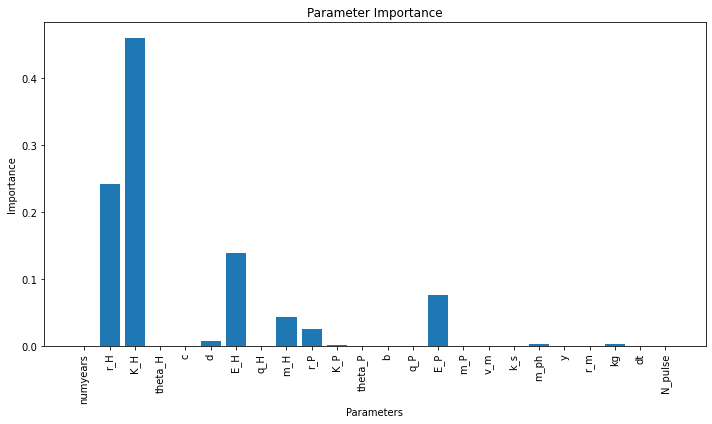

In [14]:
importances3 = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances3)

# Set up labels for the features (adjust based on your column names)
plotLabs3 = X3.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs3, importances3, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

## Simulation runs - Specialist Restored Nutrients

In [24]:
def specialist_restored_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.8/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.15/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.8/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.15/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 0.234
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

In [25]:
parameters_dict = specialist_restored_params()
params_to_vary = ['r_H', 'K_H', 'd', 'E_H', 'm_H','r_P','K_P', 'E_P', 'm_P', 'v_m', 'k_s', 'm_ph', 'r_m','y', 'kg']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/specialist_restored_RF_data.csv', index=False)

       H_final    P_final  PH_final   N_final  numyears       r_H   K_H  \
0    13.244368  10.747330  0.218110  0.013067     36500  0.000986  50.0   
1    13.499834  11.001801  0.216848  0.013193     36500  0.001011  50.0   
2    13.755504  11.254435  0.215615  0.013319     36500  0.001035  50.0   
3    14.011261  11.505137  0.214410  0.013446     36500  0.001059  50.0   
4    14.266992  11.753821  0.213234  0.013573     36500  0.001084  50.0   
..         ...        ...       ...       ...       ...       ...   ...   
145  14.371063  11.854526  0.214869  0.013565     36500  0.001096  50.0   
146  14.323728  11.808925  0.219264  0.013427     36500  0.001096  50.0   
147  14.276616  11.763467  0.223616  0.013295     36500  0.001096  50.0   
148  14.229729  11.718157  0.227925  0.013169     36500  0.001096  50.0   
149  14.183071  11.673000  0.232191  0.013048     36500  0.001096  50.0   

     theta_H         c     d       E_H  q_H       m_H       r_P   K_P  \
0          0  0.002192  50

### Run RF Analysis

In [15]:
data = pd.read_csv("data/specialist_restored_RF_data.csv")

X4 = data.iloc[:, 4:29]  # Columns 4-28 are explanatory
Y4 = data.iloc[:, 0:4]   # Columns 0-4 are response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X4, Y4)

# Predict using the model
predictions = regressor.predict(X4)

# Calculate Mean Squared Error
mse = mean_squared_error(Y4, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y4, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.0006121271302732187
R-squared: 0.9876667705773989


Feature Importances:
[0.00000000e+00 3.19658745e-01 1.15888483e-01 0.00000000e+00
 0.00000000e+00 1.73367484e-01 8.97047381e-02 0.00000000e+00
 2.32419128e-02 2.55800862e-03 9.96760448e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.49027508e-01 7.18520742e-04
 1.80654740e-06 1.48070568e-06 1.15485156e-02 3.71726166e-05
 3.05927746e-03 1.15103017e-02 0.00000000e+00 0.00000000e+00]


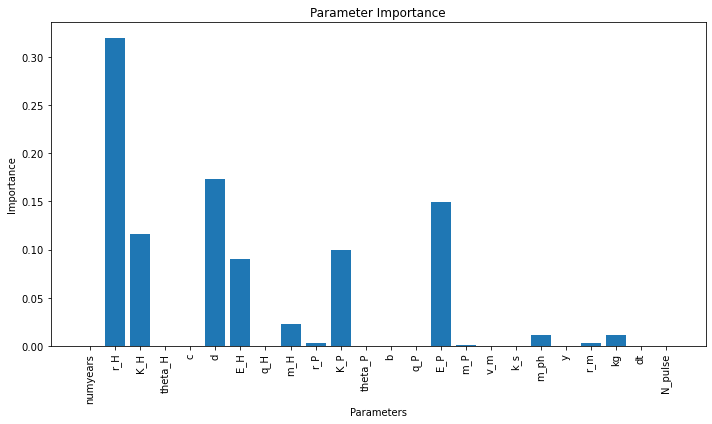

In [16]:
importances4 = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances4)

# Set up labels for the features (adjust based on your column names)
plotLabs4 = X4.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs4, importances4, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

### Filter out columns that are not of interest

In [17]:
columns_to_keep = ['r_H', 'K_H', 'd','m_H', 'E_H', 'r_P', 'K_P', 'm_P', 'E_P', 'kg', 'r_m', 'm_ph']

# Filter the columns and importances based on columns_to_keep
filtered_columns = [col for col in X1.columns if col in columns_to_keep]
filtered_importances1 = [importance for col, importance in zip(X1.columns, importances1) if col in columns_to_keep]

# Similarly, filter other importances and columns for the remaining datasets
filtered_importances2 = [importance for col, importance in zip(X2.columns, importances2) if col in columns_to_keep]
filtered_importances3 = [importance for col, importance in zip(X3.columns, importances3) if col in columns_to_keep]
filtered_importances4 = [importance for col, importance in zip(X4.columns, importances4) if col in columns_to_keep]

## Plot

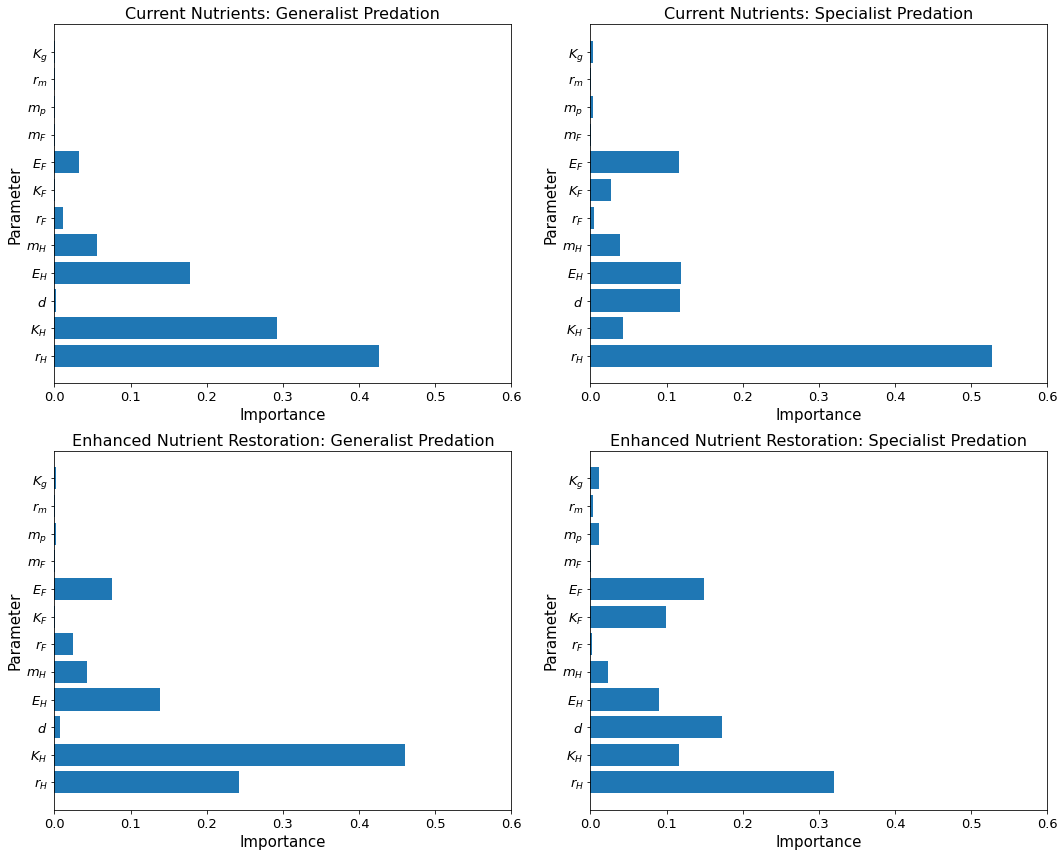

In [18]:
# Update column names *only for plotting*
plot_labels = [
    col.replace('_P', '_F').replace('m_ph', 'm_p').replace('kg', 'K_g')  
    for col in filtered_columns
]


# Format labels for LaTeX rendering in the plot
filtered_labels = [f"${col}$" for col in plot_labels]

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Define the data and labels for each subplot
datasets = [
    (filtered_importances1, filtered_labels, "Current Nutrients: Generalist Predation"),
    (filtered_importances2, filtered_labels, "Current Nutrients: Specialist Predation"),
    (filtered_importances3, filtered_labels, "Enhanced Nutrient Restoration: Generalist Predation"),
    (filtered_importances4, filtered_labels, "Enhanced Nutrient Restoration: Specialist Predation"),
]

# Loop through the datasets and plot each on a subplot
for i, (importances, plotLabs, title) in enumerate(datasets):
    ax = axs[i // 2, i % 2]  # Map 0, 1, 2, 3 to [0,0], [0,1], [1,0], [1,1]

    # Plot the feature importances as a horizontal bar chart
    ax.barh(plotLabs, importances, align="center")
    ax.set_xlim(0, 0.6)  
    ax.set_xlabel("Importance", fontsize=15)
    ax.set_ylabel("Parameter", fontsize=15)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)

# Adjust layout
plt.tight_layout()

plt.savefig("figs/random_forest_sensitivity.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

# Show the grid of plots
plt.show()


# Random Forest

In [71]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Reading in CSV file

In [72]:
data = pd.read_csv("./model_results_with_varying_params.csv")

#### Split into explanatory (X) and response (Y) variables 

In [73]:
X = data.iloc[:, 4:29]  # Columns 4-28 are explanatory
Y = data.iloc[:, 0:4]   # Columns 0-4 are response variables

#### Setup Random Forest 

In [74]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

#### Fit model to data

In [75]:
regressor.fit(X, Y)

RandomForestRegressor(random_state=42)

## Model Evaluation

#### Calculate how well the model makes predictions; calculate the mean squared error and $r^2$ 

In [77]:
# Predict using the model
predictions = regressor.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(Y, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.006720128503839543
R-squared: 0.9340610889425671


## Sensitivity Analysis 

#### Have model give importanc of each explanatory variable (i.e amount of $r^2$ value explained by a given variable)

Feature Importances:
[0.00000000e+00 6.01629709e-02 5.04780549e-01 0.00000000e+00
 0.00000000e+00 8.22318793e-02 6.44774836e-02 0.00000000e+00
 1.76273440e-02 3.83183357e-04 6.64082173e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.99883639e-01 9.09495705e-04
 1.74647187e-06 9.08653221e-07 1.07621654e-03 5.44600751e-06
 4.46272608e-04 1.60464724e-03 0.00000000e+00 0.00000000e+00]


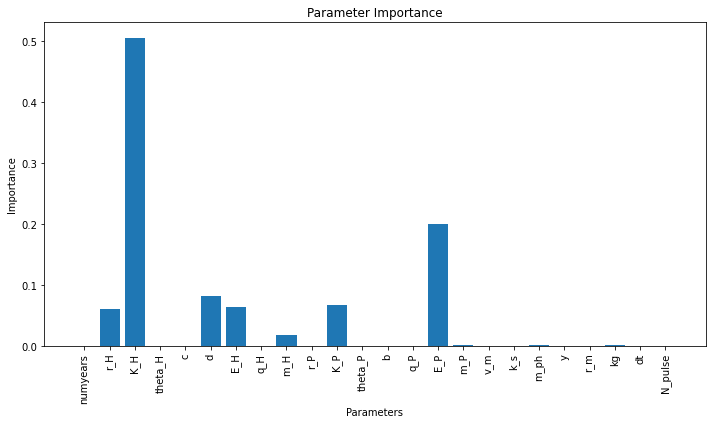

In [78]:
importances = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances)

# Set up labels for the features (adjust based on your column names)
plotLabs = X.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs, importances, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

##### Want to test these params in the facets: r_H, K_H, d, E_H, m_H, r_P, K_P, E_P, m_P, v_m, k_s, m_ph, y, r_m, kg

## If want to vary params by different amounts

In [ ]:
# Function to vary parameters and document all parameter values
def run_model_with_varying_params(parameters_dict, params_to_vary, variation_ranges, num_steps, H0, P0, PH0, N0):
    # Initialize an empty list to store all results
    all_results = []
    
    # Loop through each parameter to vary
    for param in params_to_vary:
        # Store the original value of the parameter
        original_value = parameters_dict[param]
        
        # Get the variation range for the current parameter
        if param in variation_ranges:
            param_range = variation_ranges[param]
        else:
            param_range = (original_value * 0.1)  # Default ±10% variation if not specified
        
        # Generate values to vary the parameter within the specified range and the number of steps
        varied_values = np.linspace(
            original_value - param_range,  # Lower bound
            original_value + param_range,  # Upper bound
            num_steps  # The same number of steps across all parameters
        )
        
        # Loop through each varied value for the current parameter
        for value in varied_values:
            # Update the parameter in the dictionary
            parameters_dict[param] = value
            
            # Run the model with the updated parameters
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(
                H0, P0, PH0, N0, parameters_dict
            )
            
            # Create a dictionary to store the results for this run
            result = {
                'H_final': H_array[-1],
                'P_final': P_array[-1],
                'PH_final': PH_array[-1],
                'N_final': N_array[-1]
            }
            
            # Add all parameter values to the result
            result.update(parameters_dict)
            
            # Append the result to the list
            all_results.append(result)
        
        # Reset the parameter to its original value
        parameters_dict[param] = original_value
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

# Specify parameters to vary and their custom variation ranges
params_to_vary = ['r_H', 'K_H', 'c', 'b', 'v_m', 'N_pulse', 'r_P', 'K_P', 'E_H', 'E_P']  # Parameters to vary

# Define custom variation ranges for each parameter
variation_ranges = {
    'E_P': 0.5,      # ±50% range for E_P
    'r_P': 0.0005,   # ±0.05% range for r_P
    'r_H': 0.02,     # ±2% range for r_H
    'K_H': 10,       # ±10 for K_H
    'c': 0.1,        # ±10% range for c
    'b': 0.05,       # ±5% range for b
    'v_m': 0.005,    # ±0.5% range for v_m
    'N_pulse': 0.1,  # ±10% range for N_pulse
    'K_P': 5,        # ±5 for K_P
    'E_H': 0.05      # ±5% range for E_H
}

# Set initial conditions and parameter values
parameters_dict = {
    'r_H': 0.1, 
    'K_H': 100, 
    'c': 0.5, 
    'b': 0.2, 
    'v_m': 2.0, 
    'N_pulse': 0.1, 
    'r_P': 0.001, 
    'K_P': 50, 
    'E_H': 0.5, 
    'E_P': 0.8, 
    'numyears': 36500,
    'theta_H': 0, 
    'd': 50,
    'q_H': 1.0,
    'm_H': (0.1/365),
    'theta_P': 0,
    'q_P': 1.0,
    'm_P': (0.01/365),
    'k_s': 1,
    'm_ph': 0.03,
    'y': 0.1,
    'r_m': 1.1,
    'kg': 12,
    'dt': 0.1
}

H0, P0, PH0, N0 = 100, 50, 20, 1000  # Example initial conditions

# Define the number of steps for each parameter variation (same for all parameters)
num_steps = 5

# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_ranges, num_steps, H0, P0, PH0, N0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('model_results_with_varying_params.csv', index=False)